# sequencingOverlapBetweenLibs_VennOrUpsett_and_CDF.ipynb
## Marcus Viscardi,    June 22, 2022

The last two figure we wanted to make for the paper are:
    - A VennDiagram/Upset plot to look at the coincidence of genes sequenced between libraries/techniques
    - Several CDFs looking at how many reads to a gene in 1 library coincides with that gene showing up in another library
Both of these will require fairly similar data structures (see table 1 below) that I will try to derive from featureCounts or the reads_df

Table 1 Columns:
| gene_id | polyA2_hits | polyA3_hits | totalRNA2_hits | totalRNA3_hits |

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

import scipy.stats as stats

import nanoporePipelineCommon as npCommon

from tqdm.notebook import tqdm
from pprint import pprint

import seaborn as sea
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
print("imports done!")

imports done!


In [2]:
libs_to_get = ["polyA2", "polyA3", "totalRNA2", "totalRNA3"]
lib_paths_dict = npCommon.pick_libs_return_paths_dict(libs_to_get, output_dir_folder="featureCounts", file_midfix="cat.sorted.mappedAndPrimary.bam", file_suffix="featureCounts")
libs_dict_raw = {lib: pd.read_table(path, header=None, names=["read_id", "featC_QC_tag", "featC_QC_score", "gene_id"]) for lib, path in lib_paths_dict.items()}

Looking for file for totalRNA2, at /data16/marcus/working/210720_nanoporeRun_totalRNA_0639_L3_replicate/output_dir/featureCounts/*cat.sorted.mappedAndPrimary.bam.featureCounts... File Found.
Looking for file for polyA2, at /data16/marcus/working/210719_nanoporeRun_polyA_0639_L3_replicate/output_dir/featureCounts/*cat.sorted.mappedAndPrimary.bam.featureCounts... File Found.
Looking for file for polyA3, at /data16/marcus/working/220131_nanoporeRun_polyA_0639_L3_third/output_dir/featureCounts/*cat.sorted.mappedAndPrimary.bam.featureCounts... File Found.
Looking for file for totalRNA3, at /data16/marcus/working/220131_nanoporeRun_totalRNA_0639_L3_third/output_dir/featureCounts/*cat.sorted.mappedAndPrimary.bam.featureCounts... File Found.


In [3]:
parsed_gtf_path="/data16/marcus/genomes/elegansRelease100/Caenorhabditis_elegans.WBcel235.100.gtf.parquet"
gtf_df = pd.read_parquet(parsed_gtf_path).query("feature == 'gene'")[["gene_id", "gene_name", "gene_biotype"]]
libs_dict = {lib: df[["read_id", "gene_id", "featC_QC_tag"]].copy().merge(gtf_df, on="gene_id", how="left") for lib, df in libs_dict_raw.items()}

In [4]:
counts_dict = {}
for lib, df in libs_dict.items():
    count_df = df.value_counts("gene_id").to_frame().reset_index()
    count_df.rename(columns={0: f"counts_{lib}"}, inplace=True)
    counts_dict[lib] = count_df
counts_dict

{'totalRNA2':               gene_id  counts_totalRNA2
 0      WBGene00010960              8499
 1      WBGene00010962              7172
 2      WBGene00010964              4988
 3      WBGene00001168              4541
 4      WBGene00004494              4108
 ...               ...               ...
 12510  WBGene00012178                 1
 12511  WBGene00012176                 1
 12512  WBGene00012172                 1
 12513  WBGene00012135                 1
 12514  WBGene00012603                 1
 
 [12515 rows x 2 columns],
 'polyA2':               gene_id  counts_polyA2
 0      WBGene00010960          15064
 1      WBGene00010962          14225
 2      WBGene00004494           9347
 3      WBGene00001168           7856
 4      WBGene00010965           7700
 ...               ...            ...
 13736  WBGene00012787              1
 13737  WBGene00022032              1
 13738  WBGene00012798              1
 13739  WBGene00012799              1
 13740  WBGene00000001              1


In [95]:
# Below method is from: https://www.codegrepper.com/code-examples/python/4+way+merge+in+dataframe
# Not sure how I feel about it, but it's fast!
from functools import reduce
merge_df = reduce(lambda left, right: pd.merge(left, right, on="gene_id", how="outer"), counts_dict.values()).fillna(0.0)
merge_type = "left"  # left (for just hit genes) or outer (for all genes)
merge_df = merge_df.merge(gtf_df, on="gene_id", how=merge_type)
for lib in libs_to_get:
    merge_df.fillna(value=0.0, inplace=True)
    merge_df[f'hit_in_{lib}'] = merge_df[f'counts_{lib}'] >= 1
merge_df

,gene_id,counts_totalRNA2,counts_polyA2,counts_polyA3,counts_totalRNA3,gene_name,gene_biotype,hit_in_polyA2,hit_in_polyA3,hit_in_totalRNA2,hit_in_totalRNA3
0,WBGene00010960,8499.0,15064.0,6914.0,8248.0,atp-6,protein_coding,True,True,True,True
1,WBGene00010962,7172.0,14225.0,8008.0,8014.0,ctc-3,protein_coding,True,True,True,True
2,WBGene00010964,4988.0,7690.0,2919.0,5066.0,ctc-1,protein_coding,True,True,True,True
3,WBGene00001168,4541.0,7856.0,11861.0,8815.0,eef-1A.1,protein_coding,True,True,True,True
4,WBGene00004494,4108.0,9347.0,14099.0,8952.0,rps-25,protein_coding,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
16111,WBGene00021238,0.0,0.0,0.0,1.0,gap-3,protein_coding,False,False,False,True
16112,WBGene00021199,0.0,0.0,0.0,1.0,Y17G9B.2,protein_coding,False,False,False,True
16113,WBGene00014542,0.0,0.0,0.0,1.0,W04G5.11,snRNA,False,False,False,True
16114,WBGene00014370,0.0,0.0,0.0,1.0,F40G12.13,snRNA,False,False,False,True


In [96]:
def boolDF_to_upsetPlot(input_df: pd.DataFrame,
                        show_percentages=False, show_counts=True,
                        file_name=None, min_subset_size=0, min_degree=0,
                        sort_by='cardinality', sort_categories_by='cardinality'):
    import upsetplot
    import matplotlib.pyplot as plt
    upset_format_data = upsetplot.from_indicators(lambda lambda_df: lambda_df.select_dtypes(bool), data=input_df)
    fig = plt.figure()
    upset = upsetplot.UpSet(upset_format_data, sort_by=sort_by, sort_categories_by=sort_categories_by,
                            min_subset_size=min_subset_size, min_degree=min_degree, show_percentages=show_percentages, show_counts=show_counts)
    upset.plot(fig=fig)
    if isinstance(file_name, str):
        fig.savefig(file_name)

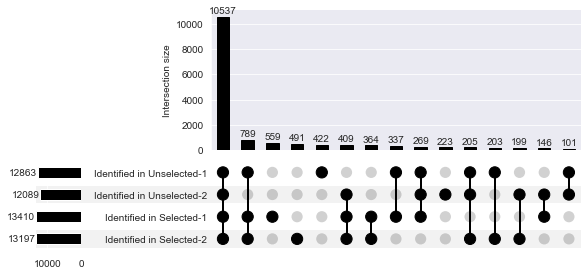

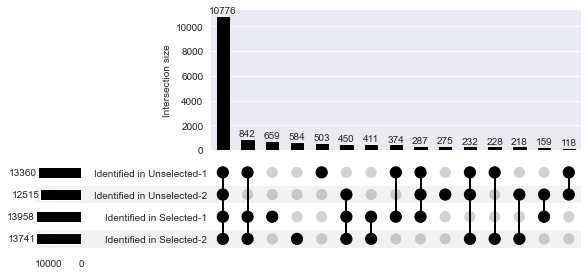

In [99]:
file_type = "svg"

merge_df.rename(columns={
    "hit_in_polyA3": "Identified in Selected-1",
    "hit_in_polyA2": "Identified in Selected-2",
    "hit_in_totalRNA3": "Identified in Unselected-1",
    "hit_in_totalRNA2": "Identified in Unselected-2"
}, inplace=True)

boolDF_to_upsetPlot(merge_df.query("gene_biotype == 'protein_coding'"), sort_categories_by=None, file_name=f"/home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/polyAvsTotalRNA_ReviewEditsAndPlots/final_SVGs//{npCommon.get_dt(for_file=True)}_upset_libraryGeneCoverage_proteinCoding_proteinCodingOnly.{file_type}")
boolDF_to_upsetPlot(merge_df, sort_categories_by=None, file_name=f"/home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/polyAvsTotalRNA_ReviewEditsAndPlots/final_SVGs/{npCommon.get_dt(for_file=True)}_upset_libraryGeneCoverage_ALLGENES.{file_type}")

## The "CDF" part:

So Josh thinks we should make something that isn't *really* a CDF, but would look somewhat similar to a 1 - CDF plot. Here is the idea:
   - x-axis = a cutoff, filtering the gene counts dataframe down to genes with hits >= X.

   - y-axis = for all of the genes with hits >= X; how many of them were hit AT ALL in the other library.

For now I think this will require doing this iteratively, but that's okay for a first test.

**Let's try it! First with totalRNA3 vs polyA3:**

In [121]:
def plot_cdf_thing(input_df, x_lib, y_lib, save_path=None):
    df = input_df[["gene_id", "gene_name", f"counts_{x_lib}", f"counts_{y_lib}", f"hit_in_{x_lib}", f"hit_in_{y_lib}"]]
    max_x_value = df[f"counts_{x_lib}"].max()
    plot_y_values = np.zeros(int(max_x_value), float)
    cdf_calc_iterator = tqdm(enumerate(plot_y_values), desc=f"Calculating CDF", total=max_x_value)
    for x, y in cdf_calc_iterator:
        df = df[df[
                    f"counts_{x_lib}"] >= x]  # We can do this continuously with a smaller and smaller df, b/c everything after one x position will be in the current x position
        plot_y_values[x] = (df.shape[0] - df[f"hit_in_{y_lib}"].sum()) / df.shape[0]
    fig = go.Figure(
        go.Scatter(
            x=np.arange(len(plot_y_values))[1:],
            y=plot_y_values[1:]
        ))
    
    library_name_conversion = {
    "polyA3": "Selected-1",
    "polyA2": "Selected-2",
    "totalRNA3": "Unselected-1",
    "totalRNA2": "Unselected-2"}
    fig.update_layout(
        title=f"<b><i>{library_name_conversion[y_lib]}</i>/<i>{library_name_conversion[x_lib]}</i></b><br>"
              f"Full coverage (Y = 0) at x = {np.where(plot_y_values == 0)[0][0]}",
        yaxis_title=f'Fraction of genes not hit in {library_name_conversion[y_lib]}',
        xaxis_title=f'Genes with hit counts >= X in {library_name_conversion[x_lib]}',
        template="plotly_white",
        width=300, height=500,
    )
    fig.update_xaxes(range=[-5, 40])
    fig.update_yaxes(range=[-0.01, 0.15])
    if isinstance(save_path, str):
        fig.write_image(save_path)
    fig.show()

In [122]:
save_path = f"/home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/polyAvsTotalRNA_ReviewEditsAndPlots/final_SVGs/{npCommon.get_dt(for_file=True)}_cdfThing"
file_type = "svg"

df_for_cdf_thing = merge_df.query("gene_biotype == 'protein_coding'").rename(columns={
    "Identified in Selected-1": "hit_in_polyA3",
    "Identified in Selected-2": "hit_in_polyA2",
    "Identified in Unselected-1": "hit_in_totalRNA3",
    "Identified in Unselected-2": "hit_in_totalRNA2"})

plot_cdf_thing(df_for_cdf_thing, "polyA2", "totalRNA2", save_path=f"{save_path}_polyA2_totalRNA2.{file_type}")

plot_cdf_thing(df_for_cdf_thing, "polyA3", "totalRNA3", save_path=f"{save_path}_polyA3_totalRNA3.{file_type}")

plot_cdf_thing(df_for_cdf_thing, "polyA2", "polyA3", save_path=f"{save_path}_polyA2_polyA3.{file_type}")

plot_cdf_thing(df_for_cdf_thing, "totalRNA2", "totalRNA3", save_path=f"{save_path}_totalRNA2_totalRNA3.{file_type}")

Calculating CDF:   0%|          | 0/15064.0 [00:00<?, ?it/s]

Calculating CDF:   0%|          | 0/14099.0 [00:00<?, ?it/s]

Calculating CDF:   0%|          | 0/15064.0 [00:00<?, ?it/s]

Calculating CDF:   0%|          | 0/8499.0 [00:00<?, ?it/s]

14